In [9]:
from pathlib import Path
import sys

import numpy as np
import sklearn.ensemble
from sklearn.datasets import make_classification
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

from deep_forest.weak_labels import SCARImputer
from deep_forest import tice
sys.path.insert(0, "..")
from positive_dropper import PositiveDropper

RANDOM_STATE = 0

In [86]:
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=3,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=2,
    weights=None,
    flip_y=0.0,
    class_sep=5,
    hypercube=True,
    shift=0.0,
    scale=1.0,
    shuffle=True,
    random_state=RANDOM_STATE,
)
X = sklearn.preprocessing.MinMaxScaler().fit_transform(X)
y = y.reshape(-1, 1)

c1, cc1 = tice.estimate_label_frequency_lower_bound(X, y, 10, most_promising_only=True)

oob_imputer = SCARImputer(
    estimator=sklearn.ensemble.RandomForestClassifier(
        n_estimators=100,
        max_depth=3,
        random_state=0,
        oob_score=True,
        bootstrap=True,
        max_samples=0.5,
    ),
    verbose=True,
)

# forest = sklearn.ensemble.RandomForestClassifier(
forest = sklearn.ensemble.RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=0,
    oob_score=True,
    bootstrap=True,
    max_samples=0.5,
)


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/sklearn/base.py:1194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0.4999943376843243] 0.0 0.5 0.5


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/sklearn/base.py:1194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0.4499911279799812] 0.1 0.5 0.45


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/sklearn/base.py:1194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0.40003939609091416] 0.2 0.5 0.4


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/sklearn/base.py:1194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0.3499928836118823] 0.30000000000000004 0.5 0.35


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/sklearn/base.py:1194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0.30002334516104756] 0.4 0.5 0.3


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/sklearn/base.py:1194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0.2500132216599396] 0.5 0.5 0.25


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/sklearn/base.py:1194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0.1999668056446809] 0.6000000000000001 0.5 0.2


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/sklearn/base.py:1194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0.15000009605409872] 0.7000000000000001 0.5 0.15


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/sklearn/base.py:1194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0.1000001799697601] 0.8 0.5 0.1


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/sklearn/base.py:1194: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0.04999734138764896] 0.9 0.5 0.05


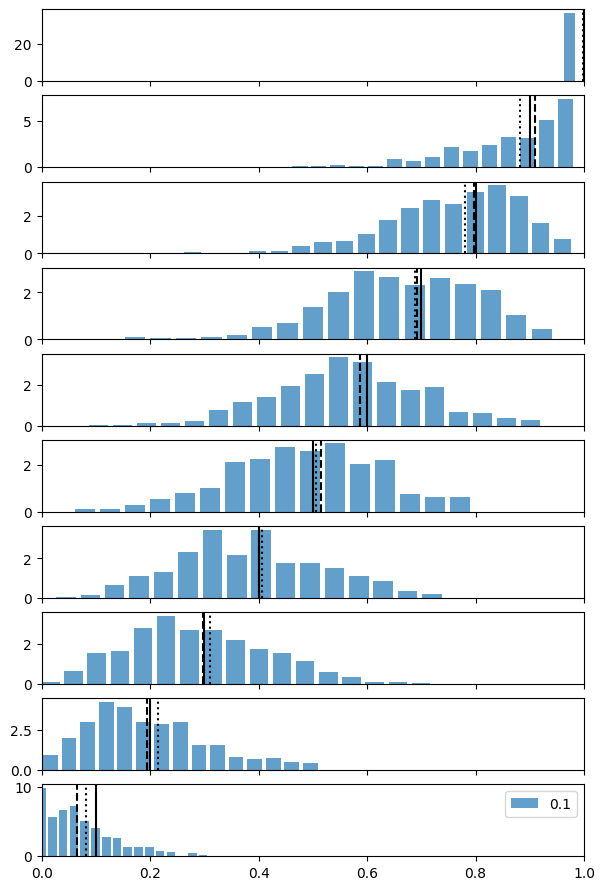

In [92]:
drop_fractions = np.linspace(0, 1, 10, endpoint=False)
n_fractions = len(drop_fractions)
fig, axs = plt.subplots(n_fractions, 1, figsize=(7, n_fractions + 1), sharex=True)

for i, drop_fraction in enumerate(drop_fractions):
    pd = PositiveDropper(drop=drop_fraction, random_state=RANDOM_STATE)
    Xt, yt = pd.fit_resample(X, y)

    if sklearn.base.is_classifier(forest):
        oob_proba = forest.fit(Xt, yt).oob_decision_function_
        oob_proba = oob_proba[:, 1]
    else:
        oob_proba = forest.fit(Xt, yt).oob_prediction_

    positives_proba = oob_proba[y.astype(bool).reshape(-1)]
    hist_1, bin_edges = np.histogram(
        positives_proba, bins="auto", density=True,
    )
    hist_all, _ = np.histogram(
        oob_proba, bins=bin_edges, density=True,
    )
    width = bin_edges[1] - bin_edges[0]

    plt.xlim(0, 1)
    axs[i].bar(
        # height=hist_1 / hist_all * yt.mean(),
        height=hist_1,
        x=bin_edges[:-1],
        width=width * 0.8,
        label=f"{1 - drop_fraction:.1f}",
        align="center",
        alpha=0.7,
    )

    # plt.hist(positives_proba, bins=30, label=f"{1 - drop_fraction:.1f}")
    axs[i].axvline(1 - drop_fraction, color="black", linestyle="solid")
    axs[i].axvline(np.percentile(positives_proba, 50), color="black", linestyle="--")
    axs[i].axvline(positives_proba.mean(), color="black", linestyle=":")
    # axs[i].axvline(np.percentile(positives_proba, 95), color="black", linestyle=":")
    # axs[i].axvline(positives_proba.max(), color="black", linestyle="dotted")

    c, cc = tice.estimate_label_frequency_lower_bound(
        Xt,
        yt,
        10,
        most_promising_only=False,
        delta=0.1,
    )
    print(c, drop_fraction, y.mean(), yt.mean())

    # axs[i].axvline(c, color="orange", linestyle=(0, (5, 10)))

plt.legend()
